In [10]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tf.enable_v2_behavior()
sns.set_style()

print(tf.__version__)
print(tfp.__version__)

2.2.0
0.10.0


In [13]:
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 20,6

In [44]:
tfb = tfp.bijectors
tfd=tfp.distributions
tfk=tfp.math.psd_kernels

In [20]:
ozone=pd.read_csv("datatest.csv")
ozone.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


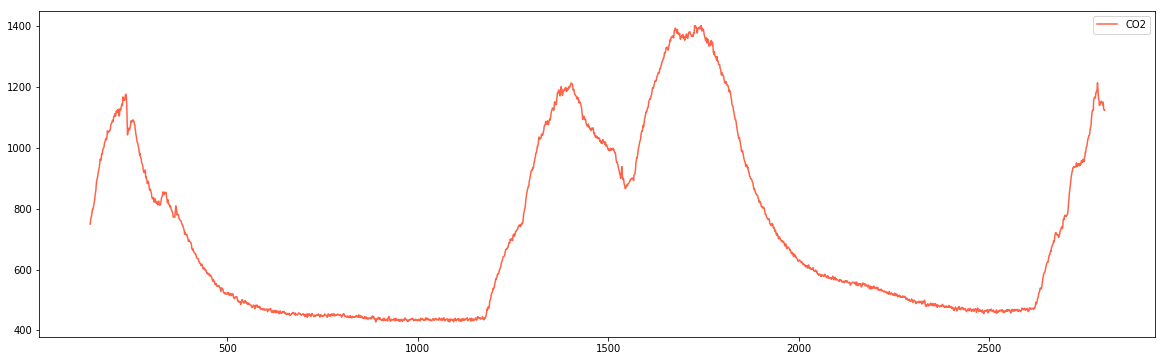

In [26]:
ozone[["CO2"]].plot(color="tomato")

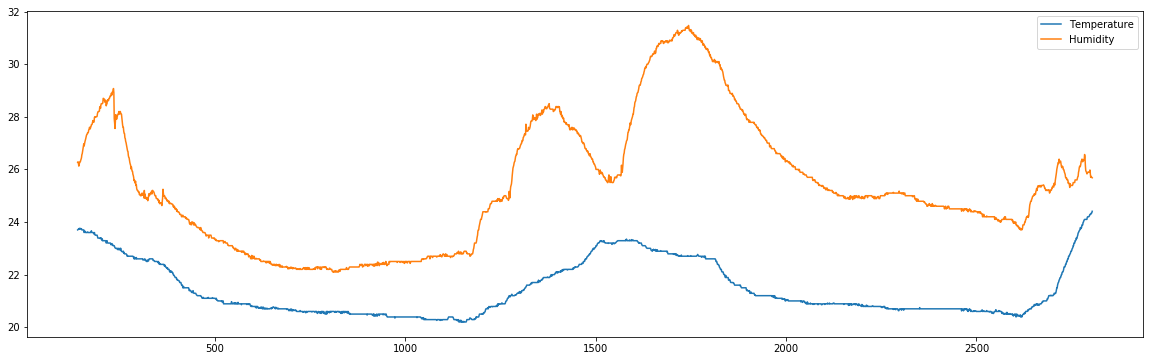

In [27]:
ozone[["Temperature", "Humidity"]].plot()

In [32]:
ozone=ozone.head(300)
ozone.shape

(300, 7)

In [116]:
train=ozone.head(200)
test=ozone.tail(100)

In [117]:
train.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
335,2015-02-02 17:34:00,22.60,25.066667,428.333333,849.333333,0.004250,0
336,2015-02-02 17:35:00,22.60,25.200000,422.500000,853.000000,0.004272,0
337,2015-02-02 17:36:00,22.60,25.200000,423.666667,853.000000,0.004272,0
338,2015-02-02 17:37:00,22.54,25.160000,424.600000,852.000000,0.004250,0
339,2015-02-02 17:38:00,22.54,25.160000,427.400000,853.600000,0.004250,0


In [136]:
num_index=200

In [146]:
index_points=np.linspace(140, 339, num_index)[..., np.newaxis]
index_points[:4]

array([[140.],
       [141.],
       [142.],
       [143.]])

In [142]:
np.linspace(140, 339, num_index)

array([140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 158., 159., 160., 161.,
       162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
       173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183.,
       184., 185., 186., 187., 188., 189., 190., 191., 192., 193., 194.,
       195., 196., 197., 198., 199., 200., 201., 202., 203., 204., 205.,
       206., 207., 208., 209., 210., 211., 212., 213., 214., 215., 216.,
       217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
       228., 229., 230., 231., 232., 233., 234., 235., 236., 237., 238.,
       239., 240., 241., 242., 243., 244., 245., 246., 247., 248., 249.,
       250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.,
       261., 262., 263., 264., 265., 266., 267., 268., 269., 270., 271.,
       272., 273., 274., 275., 276., 277., 278., 279., 280., 281., 282.,
       283., 284., 285., 286., 287., 288., 289., 29

In [140]:
kernel=tfk.ExponentiatedQuadratic()

In [172]:
#observation_index_points = np.array(train.Humidity)
observation_index_points = np.linspace(140, 339, num_index)
observations = np.array(train.CO2)

In [173]:
var=np.repeat(np.var(observations), num_index)

In [174]:
GPR=tfd.GaussianProcessRegressionModel(
    kernel=kernel, 
    index_points=index_points,
    observation_index_points=index_points,
    observations=observations
)

In [186]:
sample_GPR = GPR.sample(100)
sample_GPR

<tf.Tensor: shape=(100, 200), dtype=float64, numpy=
array([[749.19715989, 760.39869641, 769.66828254, ..., 852.99857884,
        851.99769085, 853.59662406],
       [749.20151331, 760.40038628, 769.66437307, ..., 852.99886178,
        851.99645541, 853.59793236],
       [749.19881483, 760.39857356, 769.66415521, ..., 852.99849013,
        851.99984238, 853.60001066],
       ...,
       [749.20046447, 760.3990243 , 769.66724189, ..., 852.99620168,
        851.99808996, 853.60066133],
       [749.20096743, 760.39902598, 769.66923944, ..., 852.99787144,
        852.00067293, 853.60166027],
       [749.20021983, 760.40213745, 769.66741494, ..., 853.00342502,
        852.00131747, 853.59935083]])>

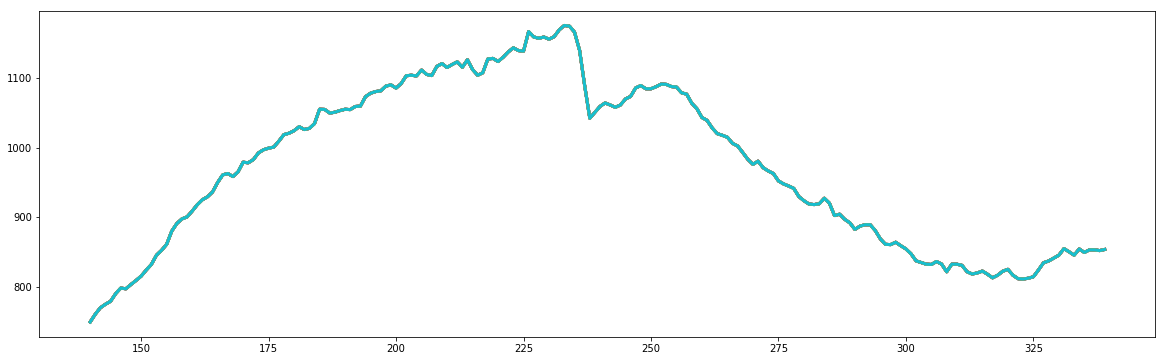

In [187]:
for i in range(10):
    plt.plot(index_points, sample_GPR[i], linewidth=3)

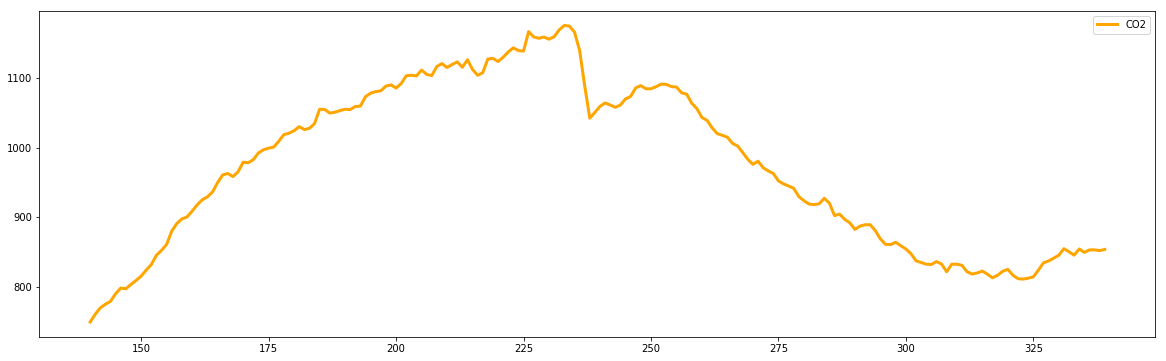

In [188]:
train[["CO2"]].plot(linewidth=3, color="orange")

In [189]:
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

In [190]:
@tf.function
def optimize():
    with tf.GradientTape() as tape:
        loss = -GPR.log_prob(observations)
    grads = tape.gradient(loss, GPR.trainable_variables)
    optimizer.apply_gradients(zip(grads, GPR.trainable_variables))
    return loss

In [191]:
# First train the model, then draw and plot posterior samples.
for i in range(1000):
    neg_log_likelihood_ = optimize()
    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

samples = GPR.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.

Step 0: NLL = -1120.579305517835
Step 100: NLL = -1120.579305517835
Step 200: NLL = -1120.579305517835
Step 300: NLL = -1120.579305517835
Step 400: NLL = -1120.579305517835
Step 500: NLL = -1120.579305517835
Step 600: NLL = -1120.579305517835
Step 700: NLL = -1120.579305517835
Step 800: NLL = -1120.579305517835
Step 900: NLL = -1120.579305517835
Final NLL = -1120.579305517835


In [170]:
samples

array([[749.19862842, 760.40200138, 769.66548821, ..., 852.99922959,
        851.99977539, 853.60028919],
       [749.19840229, 760.399404  , 769.66663686, ..., 852.99628894,
        852.00078183, 853.60168641],
       [749.20052178, 760.39916163, 769.66555663, ..., 853.0008667 ,
        851.9999948 , 853.60185741],
       ...,
       [749.19978602, 760.39937372, 769.66565065, ..., 853.00137658,
        851.9997852 , 853.59869175],
       [749.19962118, 760.40058504, 769.66602373, ..., 853.00237922,
        852.00010645, 853.60023088],
       [749.19985055, 760.39927301, 769.66449141, ..., 853.00123038,
        851.99763612, 853.5979494 ]])

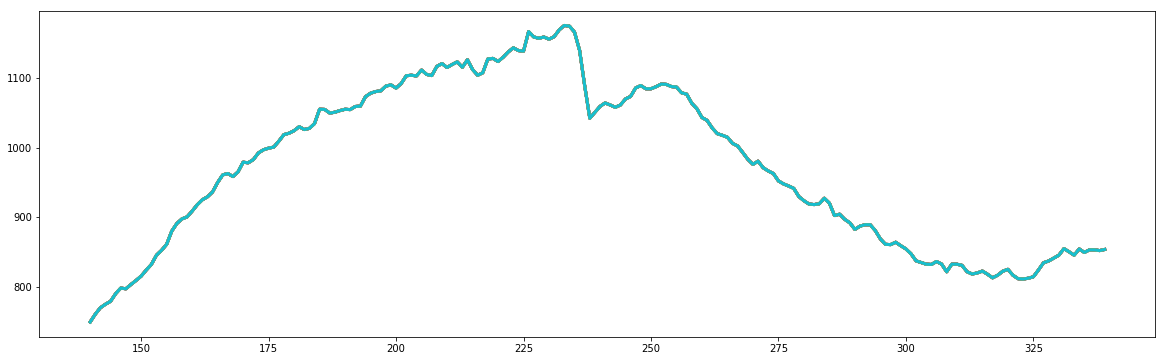

In [192]:
for i in range(10):
    plt.plot(index_points, samples[i], linewidth=3)

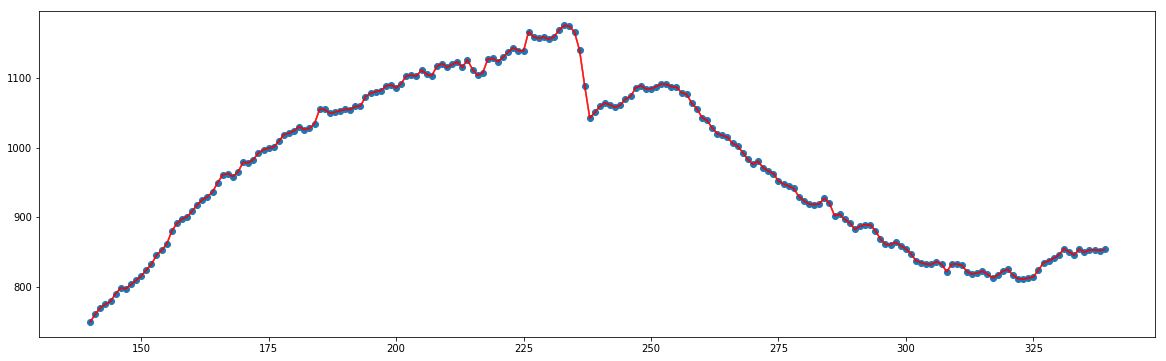

In [193]:
import matplotlib.pyplot as plt
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)